In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings

from scipy import ndimage
from skimage import filters

from PIL import Image
warnings.simplefilter('ignore')

2023-07-30 14:04:45.435919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 14:04:45.545424: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Silicon thickness
Pristine thickness:           Average around 12 microns, but up to 25 microns in particularly thick locations (like in many of the areas that form horizontal, interfacial cracks)\
Lithiated thickness:          Average around 30 microns, but up to 45 microns in particularly thick locations\
De-lithiated thickness:        Average around 22 microns, but up to 40 microns in particularly thick locations\
Re-lithiated thickness:        Average around 25 microns, but up to 50 microns in particularly thick locations

Vertical crack thicknesses (the cracks between each silicon conglomerate after de-lithiation)\
De-lithiated width:          Anywhere from 1 to 15 microns, hard to gather an average but I would say around 3-5 microns\
De-lithiated height:          Same as de-lithiated silicon thicknesses (22 to 40 microns tall)\
Re-lithiated width:          Thinner even where not close up, average around 2-3 microns\
Re-lithiated height:          Cracks close up closer to SSE first, anywhere from 5 to 20 microns tall remaining

Horizontal crack thicknesses (the cracks between certain silicon conglomerates and the solid-state electrolyte (SSE) after de-lithiation)\
De-lithiated width:          Unique to each crack, but can be anywhere from 20 to 50 microns wide\
De-lithiated height:          Very thin, 1-3 microns\
Re-lithiated width:          If the crack still exists, similar dimensions to after de-lithiation\
Re-lithiated height:          If the crack still exists, similar dimensions to after de-lithiation but slightly thinner due to compression from counter electrode (so 1-2 microns max)

In [2]:
data_dir = '/home/molel/OneDrive/PhD/Data/silicon_xct'

In [3]:
subfolders = ['horizonal-cross-sections', 'vertical-cross-sections', 'segmented-crack-volumes']

In [4]:
ignore_phase = 255
silicon_phase = 2
void_phase = 0

In [33]:
px_thresh = 254
delith_data_path = os.path.join(data_dir, 'segmented-crack-volumes', 'De-lith segmented crack volume (top down).gif')

with tf.io.gfile.GFile(delith_data_path, 'rb') as f:
    video = tf.io.decode_gif(f.read())
    data_delith = np.array(video)
    # remove scale
    data_delith[:, :, 1600:, :] = 255
    

for i in range(data_delith.shape[0]):
    arr = np.copy(data_delith[i, :, :, 0])
    print(arr.shape)
    coords_si = np.where(arr > px_thresh)
    coords_void = np.where(np.less_equal(arr, px_thresh))
    seg = np.zeros(arr.shape, dtype=np.uint8)
    seg[coords_void] = void_phase
    seg[coords_si] = silicon_phase
    img = Image.fromarray(seg)
    img.save(os.path.join('crack-volumes/delithiated', str(i).zfill(3) + ".tif"))

(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)
(1061, 1920)


In [30]:
lith_data_path = os.path.join(data_dir, 'segmented-crack-volumes', 'Re-lith segmented crack volume (top-down).gif')

with tf.io.gfile.GFile(lith_data_path, 'rb') as f:
    video = tf.io.decode_gif(f.read())
    data_lith = np.array(video)
    # remove scale
    data_lith[:, :, 1600:, :] = 255

for i in range(data_lith.shape[0]):
    arr = np.copy(data_lith[i, :, :, 0])
    coords_si = np.where(arr > px_thresh)
    coords_void = np.where(np.less_equal(arr, px_thresh))
    seg = np.zeros(arr.shape, dtype=np.uint8)
    seg[coords_void] = void_phase
    seg[coords_si] = silicon_phase
    img = Image.fromarray(seg)
    img.save(os.path.join('crack-volumes/lithiated', str(i).zfill(3) + ".tif"))

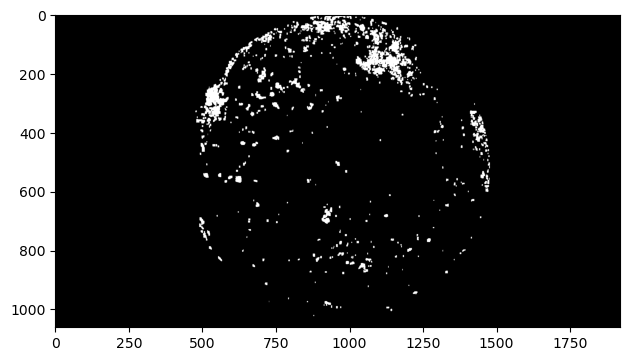

In [21]:
fig, ax = plt.subplots()
ax.imshow(data_delith[0, :, :, 0] < 255, cmap='gray')
plt.tight_layout()

In [31]:
idx = 1
img = plt.imread(os.path.join('crack-volumes/lithiated', str(idx).zfill(3) + ".tif"))

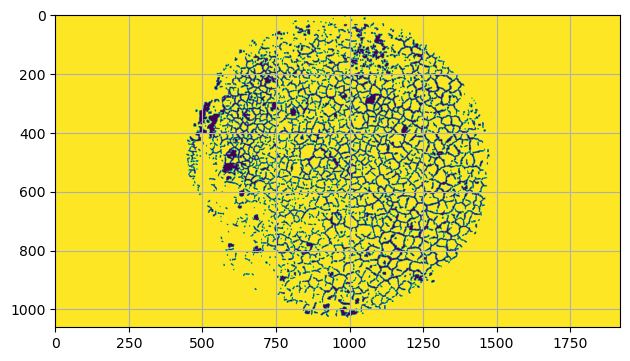

In [32]:
fig, ax = plt.subplots()
ax.imshow(img)#[1000:1040, 1765:1835])
ax.grid(which='both')
plt.tight_layout()

In [11]:
img_edges = filters.meijering(img)

In [12]:
img_edges.shape

(1061, 1920, 3)

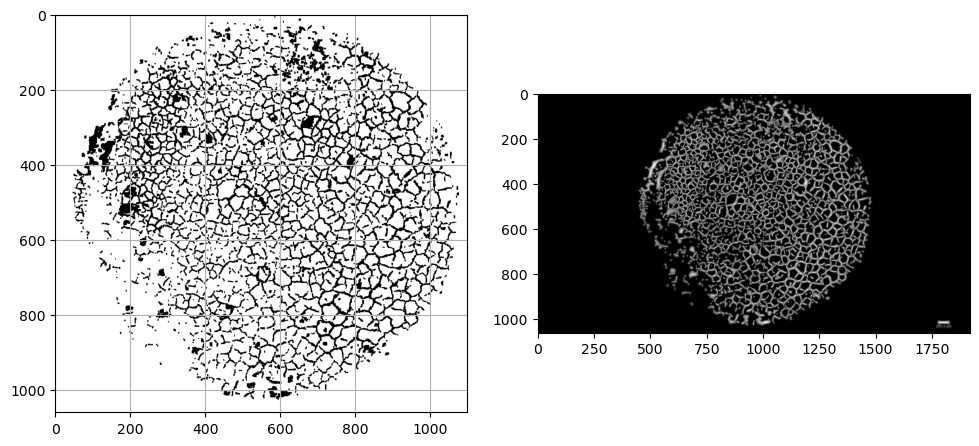

In [66]:
fig, ax  = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img[:, 400:1501])
ax[1].imshow(img_edges)
ax[0].grid()
plt.tight_layout()

In [67]:
cracks = np.greater_equal(img_edges[:, :, 0], 0.01)
coords = np.where(np.greater(cracks, 0))
ycom, xcom = map(np.average, coords)

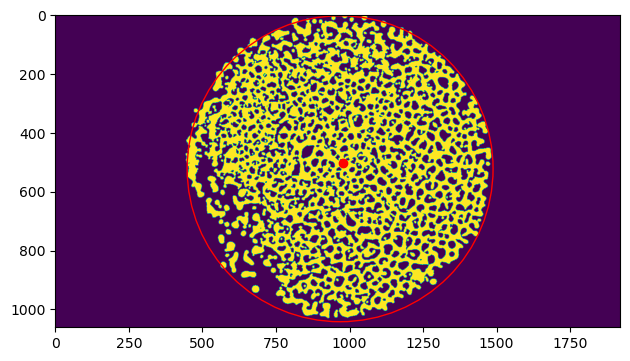

In [59]:
fig, ax = plt.subplots()
ax.imshow(cracks);
ax.plot([xcom], [ycom], 'o', color='red');
circle = plt.Circle((xcom - 10, ycom + 20), 520, fill=False, color='r')
ax.add_patch(circle)
plt.tight_layout()